In [1]:
using PyCall
using LinearAlgebra
using Random
using Printf
using MLJBase
using Plots
using BenchmarkTools
using ProfileSVG
using FLoops
using Base.Threads
using Tullio

In [2]:
abstract type Node end
#@code_warntype, @simd, @inbounds, statyczne typowenie (brak niestabilności typów, brak Any), @benchmark_tools, @btime, brak alokacji, 
#kolumny czy wiersze w for
#test co szybsz, Matrix czy Array{Float64, 2}
#softmax backward

mutable struct Conv2DNode <: Node
    x::Array{Float64, 4}
    W::Array{Float64, 4}
    b::Vector{Float64}
    batch_size::Int 
    kernel_size::Tuple{Int, Int}
    filters::Int
    output::Array{Float64, 4}
    gradient_W::Array{Float64, 4}
    gradient_b::Vector{Float64}
    activation::String
    m_W::Array{Float64}
    v_W::Array{Float64}
    m_b::Array{Float64}
    v_b::Array{Float64}
end

mutable struct MaxPoolNode <: Node
    x::Array{Float64, 4}
    pool_size::Tuple{Int, Int}
    output::Array{Float64, 4}
end

mutable struct DenseNode <: Node
    x::Matrix{Float64}
    W::Matrix{Float64} 
    b::Vector{Float64}
    neurons::Int
    output::Matrix{Float64}
    gradient_W::Matrix{Float64}
    gradient_b::Matrix{Float64}
    activation::String
    m_W::Array{Float64}
    v_W::Array{Float64}
    m_b::Array{Float64}
    v_b::Array{Float64}
end

mutable struct FlattenNode <: Node
    x::Array{Float64, 4}
    output::Matrix{Float64}
    input_shape::Tuple{Int, Int, Int}
end

mutable struct ReLUNode <: Node
    x::Union{Array{Float64, 4}, Matrix{Float64}}
    output::Union{Array{Float64, 4}, Matrix{Float64}}
end

mutable struct SoftmaxNode <: Node
    x::Union{Array{Float64, 4}, Matrix{Float64}}
    output::Union{Array{Float64, 4}, Matrix{Float64}}
    loss_func::Union{Function, Nothing}
end

mutable struct SigmoidNode <: Node
    x::Union{Array{Float64, 4}, Matrix{Float64}}
    output::Union{Array{Float64, 4}, Matrix{Float64}}
    loss_func::Union{Function, Nothing}
end

mutable struct TanhNode <: Node
    x::Union{Array{Float64, 4}, Matrix{Float64}}
    output::Union{Array{Float64, 4}, Matrix{Float64}}
end

mutable struct LeakyReLUNode <: Node
    x::Union{Array{Float64, 4}, Matrix{Float64}}
    output::Union{Array{Float64, 4}, Matrix{Float64}}
    alpha::Float64
end


In [3]:
function forward!(node::Conv2DNode, x::Array{Float64, 4}) 
    @views node.x = x
    W = node.W
    b = node.b
    
    batch_size, input_height, input_width, input_channels = size(x)
    filter_height, filter_width, _, num_filters = size(W)

    output_height = 1 + (input_height - filter_height)
    output_width = 1 + (input_width - filter_width)

    output = zeros(batch_size, output_height, output_width, num_filters)
    
    @tullio output[n, i, j, f] := (sum(x[n, i+dh, j+dw, c] * W[dh+1, dw+1, c, f] for dh in 0:filter_height-1, dw in 0:filter_width-1, c in 1:input_channels)) + b[f] n ∈ 1:batch_size i ∈ 1:output_height j ∈ 1:output_width f ∈ 1:num_filters
    
    @views node.output = output
end

function forward!(node::MaxPoolNode, x::Array{Float64, 4})
    @views node.x = x
    pool_size = node.pool_size
    
    batch_size, input_height, input_width, input_channels = size(x)

    output_height = 1 + (input_height - pool_size[1]) ÷ pool_size[1]
    output_width = 1 + (input_width - pool_size[2]) ÷ pool_size[2]

    output = zeros(batch_size, output_height, output_width, input_channels)

    @floop for n in 1:batch_size
        for c in 1:input_channels
            @inbounds for j in 1:pool_size[2]:input_width-pool_size[2]+1, i in 1:pool_size[1]:input_height-pool_size[1]+1
                @inbounds output[n, 1+div(i-1, pool_size[1]), 1+div(j-1, pool_size[2]), c] = maximum(view(x, n, i:i+pool_size[1]-1, j:j+pool_size[2]-1, c))
            end
        end
    end
    
    @views node.output = output
end


function forward!(node::FlattenNode, x::Array{Float64, 4})
    node.x = x
    node.output = reshape(x, size(x, 1), :)
end

function forward!(node::DenseNode, x::Matrix{Float64})
    node.x = x
    node.output = x * node.W .+ node.b'
end

function forward!(node::ReLUNode, x::Union{Array{Float64, 4}, Matrix{Float64}})
    node.x = x
    node.output = max.(0, x)
end

function forward!(node::SoftmaxNode, x::Union{Array{Float64, 4}, Matrix{Float64}})
    node.x = x
    exp_x = exp.(x .- maximum(x, dims=2))
    node.output = exp_x ./ sum(exp_x, dims=2)
end

function forward!(node::SigmoidNode, x::Union{Array{Float64, 4}, Matrix{Float64}})
    node.x = x
    node.output = @. 1.0 / (1.0 + exp(-x))
end

function forward!(node::TanhNode, x::Union{Array{Float64, 4}, Matrix{Float64}})
    node.x = x
    node.output = tanh.(x)
end

function forward!(node::LeakyReLUNode, x::Union{Array{Float64, 4}, Matrix{Float64}})
    node.x = x
    node.output = @. ifelse(x > 0, x, node.alpha * x)
end

forward! (generic function with 9 methods)

In [4]:
function backward!(node::Conv2DNode, dy::Array{Float64, 4}, x::Array{Float64, 4})
    W = node.W

    batch_size, input_height, input_width, input_channels = size(x)
    filter_height, filter_width, num_channels, num_filters = size(W)

    dx = zeros(size(x))
    dW = zeros(size(W))
    db = zeros(size(node.b))

    @tullio dW[fi, fj, k, l] = sum(dy[n, i, j, l] * x[n, i + fi - 1, j + fj - 1, k] for n in 1:batch_size, i in 1:size(dy, 2), j in 1:size(dy, 3))
    @tullio db[l] = sum(dy[n, i, j, k] for n in 1:size(dy, 1), i in 1:size(dy, 2), j in 1:size(dy, 3), k in 1:size(dy, 4))

    return (dx, dW, db)
end

function backward!(node::MaxPoolNode, dy::Array{Float64, 4}, x::Array{Float64, 4})
    pool_size = node.pool_size
    new_size = size(node.output)
    dy = reshape(dy, new_size)
    batch_size, height, width, channels = size(x)
    dx = zeros(size(x))
    @floop for b in 1:batch_size
        for c in 1:channels
            @inbounds for j in 1:pool_size[2]:width-pool_size[2]+1, i in 1:pool_size[1]:height-pool_size[1]+1
                @inbounds window = view(x, b, i:i+pool_size[1]-1, j:j+pool_size[2]-1, c)
                @inbounds dx[b, i:i+pool_size[1]-1, j:j+pool_size[2]-1, c] .+= dy[b, i ÷ pool_size[1]+1, j ÷ pool_size[2]+1, c] .* (window .== maximum(window))
            end
        end
    end
    
    return dx
end

function backward!(node::DenseNode, dy::Matrix{Float64}, x::Matrix{Float64})
    return (dy * node.W', x' * dy, reshape(sum(dy, dims=1), :, 1))
end

function backward!(node::FlattenNode, dy::Matrix{Float64}, x::Array{Float64, 4})
    return reshape(dy, size(x, 1), node.input_shape...)
end


function backward!(node::ReLUNode, dy::Union{Array{Float64, 4}, Matrix{Float64}}, x::Union{Array{Float64, 4}, Matrix{Float64}})
    return dy .* (x .> 0)
end

function backward!(node::SigmoidNode, dy::Union{Array{Float64, 4}, Matrix{Float64}}, x::Union{Array{Float64, 4}, Matrix{Float64}})
    return dy .* (node.output .* (1.0 .- node.output))
end

function backward!(node::TanhNode, dy::Union{Array{Float64, 4}, Matrix{Float64}}, x::Union{Array{Float64, 4}, Matrix{Float64}})
    return dy .* (1.0 .- node.output .^ 2)
end

function backward!(node::LeakyReLUNode, dy::Union{Array{Float64, 4}, Matrix{Float64}}, x::Union{Array{Float64, 4}, Matrix{Float64}})
    return dy .* ifelse.(x .> 0, 1, node.alpha)
end


function backward!(node::SoftmaxNode, dy::Union{Array{Float64, 4}, Matrix{Float64}}, x::Union{Array{Float64, 4}, Matrix{Float64}})
    softmax_output = node.output
    batch_size, num_classes = size(softmax_output)

    dx = similar(dy)

    @floop @inbounds for i in 1:batch_size
        vec = view(softmax_output, i, :)
        J = diagm(vec) .- vec .* vec'
        view(dx, i, :) .= J' * view(dy, i, :)
    end

    return dx
end

backward! (generic function with 9 methods)

In [5]:
function Conv2DNode(; batch_size::Int, filters::Int, kernel_size::Tuple{Int, Int}, input_shape::Tuple{Int, Int, Int}, activation::String)
    W = randn(kernel_size[1], kernel_size[2], input_shape[3], filters) * sqrt(1 / (kernel_size[1] * kernel_size[2] * input_shape[3]))
    b = zeros(filters)

    return Conv2DNode(zeros(1,1,1,1), W, b, batch_size, kernel_size, filters, zeros(1,1,1,1), zeros(1, 1, 1, 1), zeros(1), activation, zeros(size(W)), zeros(size(W)), zeros(size(b)), zeros(size(b)))
end

function MaxPoolNode(; pool_size::Tuple{Int, Int})
    return MaxPoolNode(zeros((1, 1, 1, 1)), pool_size, zeros((1, 1, 1, 1)))
end

function DenseNode(; neurons::Int, activation::String, input_shape::Union{Tuple{Int, Int}, Tuple{Int, Int, Int}})
    W = randn(prod(input_shape), neurons) * sqrt(1 / (prod(input_shape)))
    b = zeros(neurons)

    return DenseNode(zeros(1,1), W, b, neurons, zeros((1,1)), zeros((1, 1)), zeros((1, 1)), activation, zeros(size(W)), zeros(size(W)), zeros(size(b)), zeros(size(b)))
end

function FlattenNode(; input_shape::Tuple{Int, Int, Int})
    return FlattenNode(zeros((input_shape..., 1)), zeros((1, 1)), input_shape)
end

function ReLUNode()
    return ReLUNode(zeros((1, 1, 1, 1)), zeros((1, 1, 1, 1)))
end

function SoftmaxNode()
    return SoftmaxNode(zeros((1, 1)), zeros((1, 1)), nothing)
end

function TanhNode()
    return TanhNode(zeros((1, 1)), zeros((1, 1)))
end

function SigmoidNode()
    return SigmoidNode(zeros((1, 1)), zeros((1, 1)), nothing)
end

function LeakyReLUNode(alpha::Float64)
    return LeakyReLUNode(zeros((1, 1)), zeros((1, 1)), alpha)
end

function forward_pass!(graph::Vector{Any}, x::Array{Float64, 4})
    input = x
    for node in graph
        @inbounds forward!(node, input)
        input = @views node.output
    end
    return input
end

function backward_pass!(graph::Vector{Any}, y_true::Vector{Int64})
    preds = graph[end].output
    dout  = graph[end].loss_func(preds, y_true) #loss func backpropagation

    for i in reverse(1:length(graph))
        layer = graph[i]
        prev_layer_output = i > 1 ? graph[i - 1].output : layer.x
        if hasproperty(layer, :gradient_W)
            @inbounds dout,dW,db = backward!(layer, dout, prev_layer_output)
            layer.gradient_W = dW
            layer.gradient_b = db

        else 
            @inbounds dout = backward!(layer, dout, prev_layer_output)
        end
    end
end

function onehotbatch(labels::Vector{Int64}, classes::UnitRange{Int64})
    Y = zeros(Int, length(labels), length(classes))
    for (i, label) in enumerate(labels)
        Y[i, label .== classes] .= 1
    end
    return Y
end

function graph_build(layers::Vector{Node}, loss::String)
    output = []
    for layer in layers
        push!(output, layer)
        if hasproperty(layer, :activation)
            push!(output, getActivation(layer.activation))
        end
    end
    
    if loss == "cross_entropy_loss"
        output[end].loss_func = cross_entropy_backward
    else
        error("Invalid activation function for output layer")
    end
    
    return output
end

function getActivation(name::String)
    if name == "relu"
        return ReLUNode()
    elseif name == "softmax"
        return SoftmaxNode()
    elseif name == "sigmoid"
        return SigmoidNode()
    elseif name == "tanh"
        return TanhNode()
    elseif name == "leakyrelu"
        return LeakyReLUNode(0.01)
    else 
        error("no such activation function")
    end
end

function cross_entropy_backward(y_pred::Matrix{Float64}, y_true::Vector{Int64})
    return -(onehotbatch(y_true, 0:9) ./ y_pred) ./ size(y_true, 1)
end

import Base.hasproperty
hasproperty(x, s::Symbol) = s in fieldnames(typeof(x))

hasproperty (generic function with 4 methods)

In [23]:
function update_adam!(layer::Node, learning_rate::Float64, t::Int, beta1::Float64 = 0.9, beta2::Float64 = 0.999, epsilon::Float64 = 1e-8)
    layer.m_W = beta1 * layer.m_W + (1 - beta1) * layer.gradient_W
    layer.v_W = beta2 * layer.v_W + (1 - beta2) * layer.gradient_W .^ 2
    mhat_W = layer.m_W / (1 - beta1 ^ t)
    vhat_W = layer.v_W / (1 - beta2 ^ t)
    layer.W .-= learning_rate .* mhat_W ./ (sqrt.(vhat_W) .+ epsilon)


    layer.m_b = beta1 * layer.m_b + (1 - beta1) * layer.gradient_b
    layer.v_b = beta2 * layer.v_b + (1 - beta2) * layer.gradient_b .^ 2
    mhat_b = layer.m_b / (1 - beta1 ^ t)
    vhat_b = layer.v_b / (1 - beta2 ^ t)
    layer.b .-= learning_rate .* mhat_b ./ (sqrt.(vhat_b) .+ epsilon)
end

function update_sgd!(layer::Node, learning_rate::Float64)
    layer.W .-= learning_rate .* layer.gradient_W
    layer.b .-= learning_rate .* layer.gradient_b
end

function train!(graph::Vector{Any}, train_x::Array{Float64, 4}, train_y::Vector{Int64}, epochs::Int=5, batch_size::Int=32, learning_rate::Float64=1e-3, optimizer::String="adam")
    total_batches = ceil(Int, size(train_x, 1) / batch_size)
    each = ceil(Int, total_batches/10)
 
    loss_history = zeros(ceil(Int, total_batches*epochs/each))
    counter = 1
    
    for epoch in 1:epochs
        println("----EPOCH $epoch----")

        idx = randperm(size(train_x, 1))
        train_x = train_x[idx, :, :, :]
        train_y = train_y[idx]
        loss = 0
        current_epoch_loss = zeros(total_batches)
        

        for i in 1:batch_size:size(train_x, 1)
            x_batch = train_x[i:min(i+batch_size-1, end), :, :, :]
            y_batch = train_y[i:min(i+batch_size-1, end)]
            tmp  = (i ÷ batch_size)

            forward_pass!(graph, x_batch)
            
            current_epoch_loss[tmp+1] = -sum(log.(graph[end].output) .* onehotbatch(y_batch, 0:9))#/size(y_batch, 1)
            
            backward_pass!(graph, y_batch)

            for layer in graph
                if hasproperty(layer, :gradient_W)
                    if optimizer == "adam"
                        update_adam!(layer, learning_rate, i)
                    elseif optimizer == "sgd"
                        update_sgd!(layer, learning_rate)
                    else
                        error("Invalid optimizer selected.")
                    end
                end
            end

            
            if i == 1  ||  tmp % each == 0
                avg_loss = sum(current_epoch_loss)/(tmp+1)

                loss_history[counter] = avg_loss
                counter += 1
                print(i ÷ batch_size, "/", total_batches)
                println(" avg epoch loss: ", round(avg_loss, digits=5))
                
            end
        end
        println()
        
    end
    println("Training finished!")

    return loss_history
end

function evaluate(graph::Vector{Any}, x_data::Array{Float64, 4}, y_data::Vector{Int64}, batch_size::Int, pool_size::Tuple{Int, Int})
    num_correct = 0
    num_samples = size(x_data, 1)

    for i in 1:batch_size:num_samples
        x_batch = x_data[i:min(i+batch_size-1, end), :, :, :]
        y_batch = y_data[i:min(i+batch_size-1, end)]
        
        forward_pass!(graph, x_batch)
        pred = graph[end].output
        
        predictions = argmax.(eachrow(pred)) .- 1
        num_correct += sum(predictions .== y_batch)
    end

    accuracy = num_correct / num_samples
    return accuracy
end

function plot_loss(loss::Vector{Float64}, epochs::Int)
    plot(1:size(loss,1), loss, label="loss_batches")

    each = Int64(size(loss,1)/epochs)
    pts = loss[each:each:end]
    plot!(each:each:each*size(pts,1), pts, seriestype=:scatter, label="epochs")
end

function classification_report(y_true::Array{Int}, y_pred::Array{Int})
    labels = sort(unique(y_true))
    num_classes = length(labels)
    tp = zeros(Int, num_classes)
    fp = zeros(Int, num_classes)
    fn = zeros(Int, num_classes)

    for i in 1:num_classes
        tp[i] = sum((y_true .== labels[i]) .& (y_pred .== labels[i]))
        fp[i] = sum((y_true .!= labels[i]) .& (y_pred .== labels[i]))
        fn[i] = sum((y_true .== labels[i]) .& (y_pred .!= labels[i]))
    end

    precision = tp ./ (tp .+ fp)
    recall = tp ./ (tp .+ fn)
    f1_score = 2 * (precision .* recall) ./ (precision .+ recall)
    support = tp .+ fn
    total_support = sum(support)
    weighted_precision = sum(precision .* support) / total_support
    weighted_recall = sum(recall .* support) / total_support
    weighted_f1_score = sum(f1_score .* support) / total_support

    println("Class \t\t Precision \t Recall \t F1-score \t Support")
    for i in 1:num_classes
        @printf("%-10d \t %-10.4f \t %-10.4f \t %-10.4f \t %d \n", labels[i], precision[i], recall[i], f1_score[i], support[i])
    end

    println("------------------------------------------------")
    @printf("Avg/Total \t %-10.4f \t %-10.4f \t %-10.4f \t %d\n", weighted_precision, weighted_recall, weighted_f1_score, total_support)


end

function plot_confusion_matrix(y_true::Array{Int}, y_pred::Array{Int})
    labels = sort(unique(y_true))
    cm = Matrix(MLJBase.confusion_matrix(y_true, y_pred).mat)
    heatmap(labels,labels, cm, c = :Reds_8, title="Confusion Matrix", size=(700, 700))

    for i in 1:size(cm, 1)
        for j in 1:size(cm, 2)
            annotate!([(i-1, j-1, Plots.text(string(cm[j, i]), 10, :black, :center))])
        end
    end

    xlabel!("Predicted")
    ylabel!("Actual")
end

function predict(graph::Vector{Any}, x::Array{Float64, 4}, batch_size::Int)
    num_samples = size(x, 1)
    num_batches = ceil(Int, num_samples / batch_size)

    class_labels = zeros(Int, num_samples)

    for i in 1:batch_size:num_samples
        x_batch = x[i:min(i + batch_size - 1, end), :, :, :]
        preds = forward_pass!(graph, x_batch)
        max_indices = argmax.(eachrow(preds)) .- 1
        class_labels[i:min(i + batch_size - 1, end)] = vec(max_indices)
    end

    return class_labels
end


predict (generic function with 1 method)

In [26]:
mnist = pyimport("mnist")

# Load the MNIST dataset
train_data = mnist.train_images()
train_labels = Int64.(mnist.train_labels())
train_x =  reshape(train_data, :, 28, 28, 1) / 255.0
train_y = train_labels


n = 60000
idx = randperm(n)
train_x = train_x[idx, :,:,:]
train_y = train_y[idx]

train_y[1]

2

----EPOCH 1----

0/469 avg epoch loss: 295.00884


47/469 avg epoch loss: 84.68103


94/469 avg epoch loss: 54.62474


141/469 avg epoch loss: 42.35549

188/469 avg epoch loss: 35.36321


235/469 avg epoch loss: 30.95325


282/469 avg epoch loss: 27.86418


329/469 avg epoch loss: 25.48687


376/469 avg epoch loss: 23.65277

423/469 avg epoch loss: 22.20937


----EPOCH 2----


0/469 avg epoch loss: 0.92477


47/469 avg epoch loss: 6.51782


94/469 avg epoch loss: 7.37685


141/469 avg epoch loss: 7.41049


188/469 avg epoch loss: 7.81176


235/469 avg epoch loss: 7.68266


282/469 avg epoch loss: 7.65786


329/469 avg epoch loss: 7.58068


376/469 avg epoch loss: 7.58794


423/469 avg epoch loss: 7.46602



----EPOCH 3----

0/469 avg epoch loss: 4.45705


47/469 avg epoch loss: 6.14909


94/469 avg epoch loss: 6.08767


141/469 avg epoch loss: 6.15633


188/469 avg epoch loss: 5.68632


235/469 avg epoch loss: 5.89131


282/469 avg epoch loss: 5.73037


329/469 avg epoch loss: 5.88156


376/469 avg epoch loss: 5.81365


423/469 avg epoch loss: 5.79014



----EPOCH 4----


0/469 avg epoch loss: 9.0096


47/469 avg epoch loss: 4.6455


94/469 avg epoch loss: 4.29401


141/469 avg epoch loss: 4.2947


188/469 avg epoch loss: 4.53215


235/469 avg epoch loss: 4.53266


282/469 avg epoch loss: 4.38799


329/469 avg epoch loss: 4.44557


376/469 avg epoch loss: 4.6294


423/469 avg epoch loss: 4.71067



----EPOCH 5----


0/469 avg epoch loss: 3.9297


47/469 avg epoch loss: 3.13709


94/469 avg epoch loss: 3.26245


141/469 avg epoch loss: 3.54969


188/469 avg epoch loss: 3.58903


235/469 avg epoch loss: 3.61722


282/469 avg epoch loss: 3.49521


329/469 avg epoch loss: 3.71029


376/469 avg epoch loss: 3.59549


423/469 avg epoch loss: 3.66376



----EPOCH 6----


0/469 avg epoch loss: 1.69346


47/469 avg epoch loss: 2.99038


94/469 avg epoch loss: 2.95417


141/469 avg epoch loss: 2.9195


188/469 avg epoch loss: 2.96438


235/469 avg epoch loss: 2.86167


282/469 avg epoch loss: 2.92894


329/469 avg epoch loss: 3.00683


376/469 avg epoch loss: 2.97838


423/469 avg epoch loss: 2.98899



----EPOCH 7----


0/469 avg epoch loss: 7.56967


47/469 avg epoch loss: 2.33441


94/469 avg epoch loss: 2.31261

141/469 avg epoch loss: 2.26774


188/469 avg epoch loss: 2.6964


235/469 avg epoch loss: 2.80162


282/469 avg epoch loss: 2.80344


329/469 avg epoch loss: 2.74713


376/469 avg epoch loss: 2.82115


423/469 avg epoch loss: 2.83167



----EPOCH 8----


0/469 avg epoch loss: 0.9207


47/469 avg epoch loss: 2.33781


94/469 avg epoch loss: 2.45278


141/469 avg epoch loss: 2.44379


188/469 avg epoch loss: 2.60606


235/469 avg epoch loss: 2.54222

282/469 avg epoch loss: 2.61907


329/469 avg epoch loss: 2.64629


376/469 avg epoch loss: 2.58173


423/469 avg epoch loss: 2.5641



----EPOCH 9----


0/469 avg epoch loss: 2.88612


47/469 avg epoch loss: 1.75792


94/469 avg epoch loss: 2.05406


141/469 avg epoch loss: 1.91198

188/469 avg epoch loss: 1.94154


235/469 avg epoch loss: 1.96541


282/469 avg epoch loss: 2.12334


329/469 avg epoch loss: 2.20183


376/469 avg epoch loss: 2.2679


423/469 avg epoch loss: 2.33173



----EPOCH 10----


0/469 avg epoch loss: 0.86304


47/469 avg epoch loss: 1.91077


94/469 avg epoch loss: 1.85073

141/469 avg epoch loss: 1.70092


188/469 avg epoch loss: 1.85386


235/469 avg epoch loss: 1.82562


282/469 avg epoch loss: 1.83191


329/469 avg epoch loss: 1.7602


376/469 avg epoch loss: 1.91326


423/469 avg epoch loss: 2.01766



Training finished!


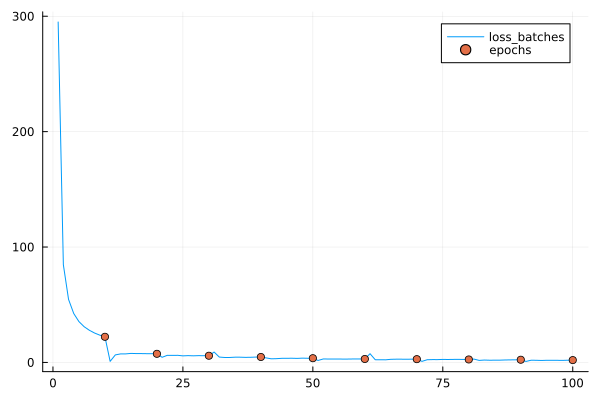

In [27]:
epochs = 10
batch_size = 128
learning_rate = 0.005
pool_size = (4,4)

model = [
    Conv2DNode(batch_size=batch_size, filters=24, kernel_size=(3,3), input_shape=(28,28,1), activation="relu"),
    MaxPoolNode(pool_size=(4,4)),
    FlattenNode(input_shape=(6,6,24)),
    DenseNode(neurons=32, activation="relu", input_shape=(prod((6,6,24)), 1)),
    DenseNode(neurons=10, activation="softmax", input_shape=(32,1))
]

graph = graph_build(model, "cross_entropy_loss")

loss = train!(graph, train_x, train_y, epochs, batch_size, learning_rate, "adam")

plot_loss(loss, epochs)

In [28]:
test_data = mnist.test_images()
test_labels = Int64.(mnist.test_labels())

test_x =  reshape(test_data, :, 28, 28, 1) / 255.0
test_y = test_labels

n = 10000
idx = randperm(n)

test_x = test_x[idx, :,:,:]
test_y = test_y[idx]

accuracy = evaluate(graph, test_x, test_y, batch_size, pool_size)
println("Accuracy: ", accuracy)

Accuracy: 0.9853


Class 		 Precision 	 Recall 	 F1-score 	 Support
0          	 0.9779     	 0.9939     	 0.9858     	 980 
1          	 0.9938     	 0.9885     	 0.9912     	 1135 
2          	 0.9865     	 0.9884     	 0.9874     	 1032 
3          	 0.9784     	 0.9871     	 0.9828     	 1010 
4          	 0.9898     	 0.9908     	 0.9903     	 982 
5          	 0.9831     	 0.9753     	 0.9792     	 892 
6          	 0.9926     	 0.9802     	 0.9863     	 958 
7          	 0.9816     	 0.9854     	 0.9835     	 1028 
8          	 0.9826     	 0.9877     	 0.9852     	 974 
9          	 0.9860     	 0.9742     	 0.9801     	 1009 
------------------------------------------------
Avg/Total 	 0.9853     	 0.9853     	 0.9853     	 10000


┌ Warning: The classes are un-ordered,
│ using order: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase C:\Users\anczo\.julia\packages\MLJBase\g5E7V\src\measures\confusion_matrix.jl:122


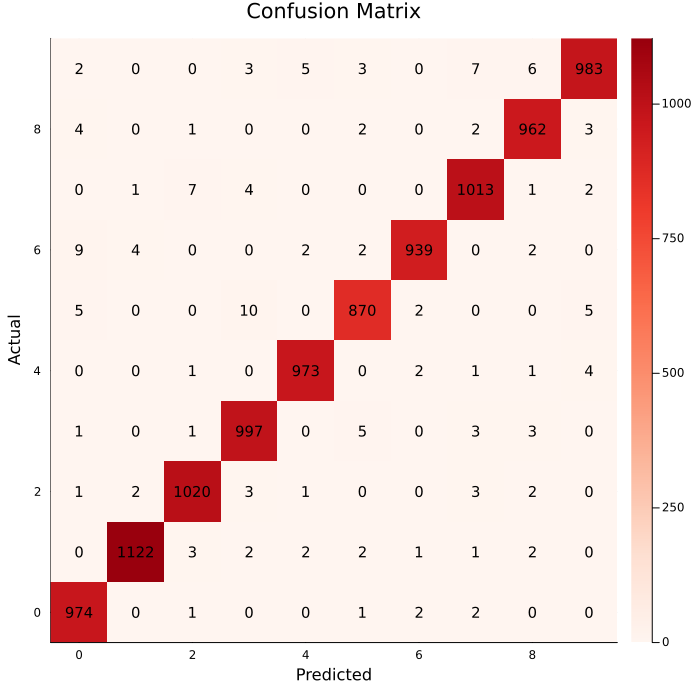

In [29]:
pred_y = predict(graph, test_x, batch_size)
classification_report(test_y, pred_y)
plot_confusion_matrix(test_y, pred_y)

----EPOCH 1----


0/469 avg epoch loss: 303.09483


47/469 avg epoch loss: 288.90456


94/469 avg epoch loss: 279.01547


141/469 avg epoch loss: 269.19691


188/469 avg epoch loss: 258.64979


235/469 avg epoch loss: 247.43127


282/469 avg epoch loss: 236.0356


329/469 avg epoch loss: 224.65122


376/469 avg epoch loss: 213.63338


423/469 avg epoch loss: 203.33425


----EPOCH 2----


0/469 avg epoch loss: 114.44313


47/469 avg epoch loss: 96.02495


94/469 avg epoch loss: 93.22761


141/469 avg epoch loss: 90.25342


188/469 avg epoch loss: 87.76762


235/469 avg epoch loss: 85.48411


282/469 avg epoch loss: 83.51939


329/469 avg epoch loss: 81.78435


376/469 avg epoch loss: 79.81547


423/469 avg epoch loss: 78.40598



----EPOCH 3----


0/469 avg epoch loss: 63.66431


47/469 avg epoch loss: 61.3184


94/469 avg epoch loss: 60.36112


141/469 avg epoch loss: 59.33916


188/469 avg epoch loss: 58.63675


235/469 avg epoch loss: 57.95154


282/469 avg epoch loss: 57.29721


329/469 avg epoch loss: 56.48254


376/469 avg epoch loss: 55.62296


423/469 avg epoch loss: 55.23358



----EPOCH 4----


0/469 avg epoch loss: 47.29952


47/469 avg epoch loss: 50.41563


94/469 avg epoch loss: 48.72286


141/469 avg epoch loss: 48.16641


188/469 avg epoch loss: 47.40347


235/469 avg epoch loss: 47.30982


282/469 avg epoch loss: 46.65502


329/469 avg epoch loss: 46.22407


376/469 avg epoch loss: 46.01448


423/469 avg epoch loss: 45.88371



----EPOCH 5----


0/469 avg epoch loss: 59.38249


47/469 avg epoch loss: 42.06768


94/469 avg epoch loss: 40.76505


141/469 avg epoch loss: 41.05682

188/469 avg epoch loss: 41.56308


235/469 avg epoch loss: 41.33186


282/469 avg epoch loss: 40.84732


329/469 avg epoch loss: 40.53079


376/469 avg epoch loss: 40.47434


423/469 avg epoch loss: 40.35425


----EPOCH 6----


0/469 avg epoch loss: 40.30241


47/469 avg epoch loss: 36.94079


94/469 avg epoch loss: 38.0327


141/469 avg epoch loss: 37.67841


188/469 avg epoch loss: 37.82115


235/469 avg epoch loss: 37.48884


282/469 avg epoch loss: 37.27431

329/469 avg epoch loss: 37.13098


376/469 avg epoch loss: 36.72265


423/469 avg epoch loss: 36.66984



----EPOCH 7----

0/469 avg epoch loss: 24.6509


47/469 avg epoch loss: 34.11403


94/469 avg epoch loss: 33.71449


141/469 avg epoch loss: 32.99876


188/469 avg epoch loss: 32.98876


235/469 avg epoch loss: 33.36333


282/469 avg epoch loss: 33.52404


329/469 avg epoch loss: 33.60617


376/469 avg epoch loss: 33.50491


423/469 avg epoch loss: 33.23625



----EPOCH 8----

0/469 avg epoch loss: 27.88521

47/469 avg epoch loss: 30.8015


94/469 avg epoch loss: 30.98585


141/469 avg epoch loss: 31.04857


188/469 avg epoch loss: 31.11275


235/469 avg epoch loss: 31.044


282/469 avg epoch loss: 30.93344


329/469 avg epoch loss: 30.86067


376/469 avg epoch loss: 30.80189


423/469 avg epoch loss: 30.87487



----EPOCH 9----


0/469 avg epoch loss: 32.66886


47/469 avg epoch loss: 28.9987


94/469 avg epoch loss: 28.47575


141/469 avg epoch loss: 29.6183


188/469 avg epoch loss: 28.85095


235/469 avg epoch loss: 29.22414


282/469 avg epoch loss: 29.37302


329/469 avg epoch loss: 28.94381


376/469 avg epoch loss: 28.78225


423/469 avg epoch loss: 28.80358



----EPOCH 10----

0/469 avg epoch loss: 24.84601


47/469 avg epoch loss: 25.98562


94/469 avg epoch loss: 26.93078


141/469 avg epoch loss: 27.10772


188/469 avg epoch loss: 26.86087


235/469 avg epoch loss: 27.25056


282/469 avg epoch loss: 27.06311


329/469 avg epoch loss: 27.04255


376/469 avg epoch loss: 27.16528


423/469 avg epoch loss: 26.97864



Training finished!


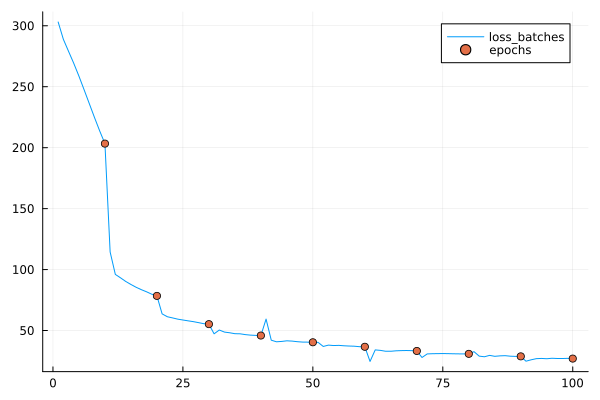

In [30]:
epochs = 10
batch_size = 128
learning_rate = 0.0075
pool_size = (4,4)

model = [
    Conv2DNode(batch_size=batch_size, filters=24, kernel_size=(3,3), input_shape=(28,28,1), activation="relu"),
    MaxPoolNode(pool_size=(4,4)),
    FlattenNode(input_shape=(6,6,24)),
    DenseNode(neurons=32, activation="relu", input_shape=(prod((6,6,24)), 1)),
    DenseNode(neurons=10, activation="softmax", input_shape=(32,1))
]

graph1 = graph_build(model, "cross_entropy_loss")

loss1 = train!(graph1, train_x, train_y, epochs, batch_size, learning_rate, "sgd")
plot_loss(loss1, epochs)

In [31]:
accuracy = evaluate(graph1, test_x, test_y, batch_size, pool_size)
println("Accuracy: ", accuracy)

Accuracy: 0.9446


Class 		 Precision 	 Recall 	 F1-score 	 Support
0          	 0.9514     	 0.9796     	 0.9653     	 980 
1          	 0.9791     	 0.9885     	 0.9838     	 1135 
2          	 0.9454     	 0.9225     	 0.9338     	 1032 
3          	 0.9456     	 0.9297     	 0.9376     	 1010 
4          	 0.9580     	 0.9532     	 0.9556     	 982 
5          	 0.9424     	 0.9350     	 0.9387     	 892 
6          	 0.9388     	 0.9603     	 0.9494     	 958 
7          	 0.9561     	 0.9105     	 0.9327     	 1028 
8          	 0.9190     	 0.9322     	 0.9256     	 974 
9          	 0.9064     	 0.9306     	 0.9183     	 1009 
------------------------------------------------
Avg/Total 	 0.9448     	 0.9446     	 0.9445     	 10000


┌ Warning: The classes are un-ordered,
│ using order: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase C:\Users\anczo\.julia\packages\MLJBase\g5E7V\src\measures\confusion_matrix.jl:122


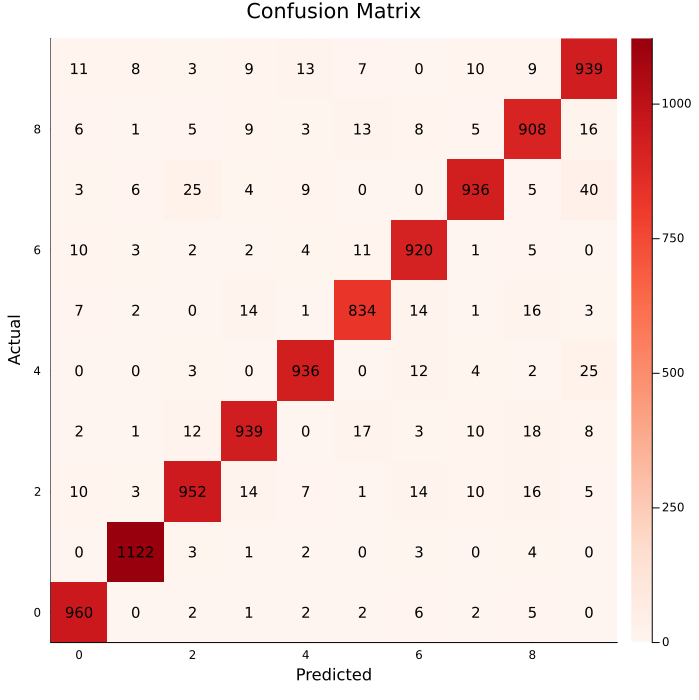

In [32]:
pred_y = predict(graph1, test_x, batch_size)
classification_report(test_y, pred_y)
plot_confusion_matrix(test_y, pred_y)

In [33]:
epochs = 1
batch_size = 128
learning_rate = 0.005
pool_size = (4,4)

model = [
    Conv2DNode(batch_size=batch_size, filters=24, kernel_size=(3,3), input_shape=(28,28,1), activation="relu"),
    MaxPoolNode(pool_size=(4,4)),
    FlattenNode(input_shape=(6,6,24)),
    DenseNode(neurons=32, activation="relu", input_shape=(prod((6,6,24)), 1)),
    DenseNode(neurons=10, activation="softmax", input_shape=(32,1))
]

graph2 = graph_build(model, "cross_entropy_loss")

@btime loss = train!(graph2, train_x, train_y, epochs, batch_size, learning_rate, "adam")

----EPOCH 1----


0/469 avg epoch loss: 292.87841


47/469 avg epoch loss: 83.28294


94/469 avg epoch loss: 53.34752


141/469 avg epoch loss: 42.12928


188/469 avg epoch loss: 35.22259


235/469 avg epoch loss: 31.36459


282/469 avg epoch loss: 28.39823


329/469 avg epoch loss: 26.09987


376/469 avg epoch loss: 24.18567


423/469 avg epoch loss: 22.71904



Training finished!


----EPOCH 1----

0/469 avg epoch loss: 10.31141


47/469 avg epoch loss: 9.6337


94/469 avg epoch loss: 9.44679


141/469 avg epoch loss: 9.39854


188/469 avg epoch loss: 9.34744


235/469 avg epoch loss: 8.95855


282/469 avg epoch loss: 8.86426

329/469 avg epoch loss: 8.67153


376/469 avg epoch loss: 8.50264


423/469 avg epoch loss: 8.3944



Training finished!


----EPOCH 1----


0/469 avg epoch loss: 11.4694


47/469 avg epoch loss: 6.21425


94/469 avg epoch loss: 6.07267


141/469 avg epoch loss: 6.21371


188/469 avg epoch loss: 6.09561


235/469 avg epoch loss: 6.12165


282/469 avg epoch loss: 6.07482


329/469 avg epoch loss: 6.1412


376/469 avg epoch loss: 6.19435


423/469 avg epoch loss: 6.30807



Training finished!


----EPOCH 1----

0/469 avg epoch loss: 11.45249


47/469 avg epoch loss: 5.07664


94/469 avg epoch loss: 5.0029


141/469 avg epoch loss: 5.01519


188/469 avg epoch loss: 5.01351


235/469 avg epoch loss: 4.94983


282/469 avg epoch loss: 5.20806


329/469 avg epoch loss: 5.16366


376/469 avg epoch loss: 5.12523


423/469 avg epoch loss: 5.07965



Training finished!
  87.922 s (52595894 allocations: 48.60 GiB)


10-element Vector{Float64}:
 11.452492771577198
  5.076642204560884
  5.0028980886897365
  5.015190170973859
  5.013508077556265
  4.9498285289357975
  5.208062080364125
  5.16366252557863
  5.125228173961009
  5.07964614602739